# Modeling FQHC Total Health Center Funding Predictions

The goal of this notebook it to explore various regression models and their accuracy to predict the total health center funding a new entity could receive. 

During preprocessing, I saved 4 train/test splits based on:
1. whether RobustScaler() or PowerTransformer() was applied
2. whether missing data was imputed or removed

I will train and test Linear Regression models and Random Forest Regression models on the 4 data splits. I will also use PCA to reduce the number of components and add relevant components to the existing data (if this increases predictive capabilities)

All results will be scored with R2, Mean Squared Error, and Mean Absolute Error. I'll save cross-validation scoring results for the Linear Models. 

I plan to use GridSearch for the Random Forest Regressors to identify the best parameters. 

Cross-validation for all models will involve 5-fold splits. 

# Import Packages

In [180]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH, MODEL_DATA_PATH

In [182]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

## Tracking Scoring Metrics for Models

In [183]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
   
    global y_pred

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_test = root_mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f'R2 Score: {r2_test}, Root Mean Squared Error: {rmse_test}, Mean Absolute Error: {mae_test}')
    
    y_pred = y_pred_test
   
    return rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test



In [184]:
model_scores = pd.DataFrame({
                             'model_type':[],
                             'train_test_split':[],
                             'is_pca':[], 
                             'score_rmse_train':[],
                             'score_rmse_test':[],
                             'score_mae_train':[],
                             'score_mae_test':[],
                             'score_r2_train':[],
                             'score_r2_test':[],
                             'cv_mean_r2':[],
                             'cv_std_r2':[],
                             'cv_mean_rmse':[],
                             'cv_std_rmse':[],
                             'cv_mean_mae':[],
                             'cv_std_mae':[],
                             'best_params':[] 
                            })
model_scores['is_pca'] = model_scores['is_pca'].astype(bool)
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params


In [185]:
def add_model_score(model_type, train_test_split, is_pca, score_rmse_train, score_rmse_test, score_mae_train, score_mae_test, score_r2_train, score_r2_test, cv_mean_r2, cv_std_r2, cv_mean_rmse, cv_std_rmse, cv_mean_mae, cv_std_mae, best_params=None):
    """
    Adds a row to the model_scores DataFrame with the specified model performance metrics.

    Parameters:
        model_scores (pd.DataFrame): DataFrame to log the results.
        model_type (str): Type of the model.
        train_test_split (str): Description of the data split used.
        is_pca (bool): Indicates if PCA was applied.
        score_rmse (float): Root Mean Squared Error of the model.
        score_mae (float): Mean Absolute Error of the model.
        score_r2 (float): R2 Score of the model.
        cross_val_mean (float): Mean of cross-validation scores.
        cross_val_std (float): Standard deviation of cross-validation scores.
        best_params (dict): Best parameters from model tuning.

    Returns:
        pd.DataFrame: Updated DataFrame with the new model scores.
    """
    global model_scores

    new_row_df = pd.DataFrame([{
        'model_type': model_type,
        'train_test_split': train_test_split,
        'is_pca': bool(is_pca),
        'score_rmse_train': score_rmse_train,
        'score_rmse_test': score_rmse_test,
        'score_mae_train': score_mae_train,
        'score_mae_test': score_mae_test,
        'score_r2_train': score_r2_train,
        'score_r2_test': score_r2_test,
        'cv_mean_r2': cv_mean_r2,
        'cv_std_r2': cv_std_r2,
        'cv_mean_rmse': cv_mean_rmse,
        'cv_std_rmse': cv_std_rmse,
        'cv_mean_mae': cv_mean_mae,
        'cv_std_mae': cv_std_mae,
        'best_params': best_params
    }])

    model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)

In [186]:
# import train/test splits for modeling the reduced and robust scaled data
X_train_rr = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_robust.csv')
X_test_rr = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_robust.csv')

# import train/test splits for modeling the reduced and power transformed data
X_train_rp = pd.read_csv(MODEL_DATA_PATH + 'X_train_reduced_power.csv')
X_test_rp = pd.read_csv(MODEL_DATA_PATH + 'X_test_reduced_power.csv')

# import train/test splits for modeling the imputed and robust scaled data
X_train_ir = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_robust.csv')
X_test_ir = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_robust.csv')

# import train/test splits for modeling the imputed and power transformed data
X_train_ip = pd.read_csv(MODEL_DATA_PATH + 'X_train_imputed_power.csv')
X_test_ip = pd.read_csv(MODEL_DATA_PATH + 'X_test_imputed_power.csv')

y_train = pd.read_csv(MODEL_DATA_PATH + 'y_train_data.csv').values.ravel()
y_test = pd.read_csv(MODEL_DATA_PATH + 'y_test_data.csv').values.ravel()

y_train_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_train_rounded.csv').values.ravel()
y_test_rounded = pd.read_csv(MODEL_DATA_PATH + 'y_test_rounded.csv').values.ravel()

# Linear Models

## I. Reduced & Robust Scaled Data


In [187]:
print(X_train_rr.shape, y_train.shape, y_train_rounded.shape)
print(X_test_rr.shape, y_test.shape, y_test_rounded.shape)

(939, 54) (939,) (939,)
(403, 54) (403,) (403,)


### A. Linear Regression

In [188]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.5987099881669747, 0.049293575938529594),
 'neg_mean_squared_error': (-3031148605996.044, 167555256950.67242),
 'neg_mean_absolute_error': (-1150322.350841745, 37108.60169878864)}

#### Model Training and Evaluation

R2 Score: -0.29324276253507, Root Mean Squared Error: 3040477.797774148, Mean Absolute Error: 1240233.9928990544


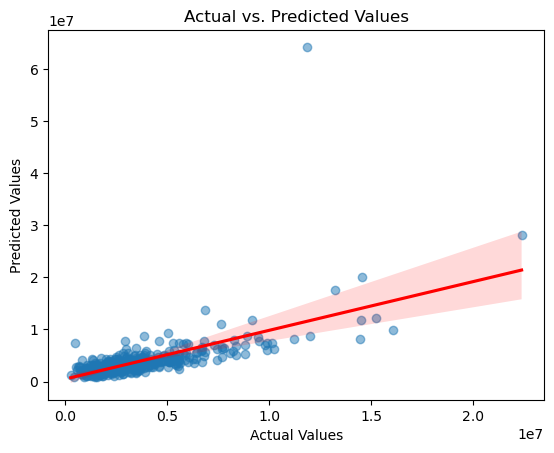

In [189]:
linear_model.fit(X_train_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', bool(False), 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [190]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.508451e+06,3.040478e+06,1.034526e+06,1.240234e+06,0.703222,-0.293243,0.59871,0.049294,-3.031149e+12,1.675553e+11,-1.150322e+06,37108.601699,None


### B. Linear Regression with PCA

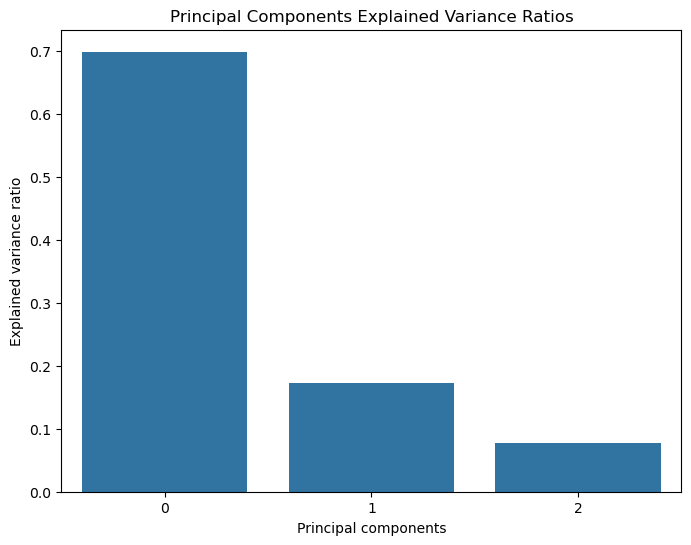

                             PC 1      PC 2      PC 3
public_insurance         0.955847  0.002913 -0.289544
public_insurance_ratio   0.292071 -0.053051  0.952575
public_housing_patients  0.012504  0.031431 -0.029566
total_other_revenue      0.011502  0.006497 -0.031096
lep_patients             0.011393  0.030770 -0.020317
migrant_patients         0.011018  0.982568  0.055799
hispanic_any_race        0.009456  0.044173 -0.018429
medicaid                 0.007005  0.028729 -0.016049
total_patients           0.006957  0.022060 -0.015698
uninsured                0.006923  0.015501 -0.013596
diverse_patients_sum     0.006893  0.003537 -0.012106
total_grant_funding      0.005799  0.013278 -0.012184
low_income               0.005742  0.030094 -0.011599
homeless_patients        0.005214  0.021706 -0.017198
private_insurance        0.004356  0.011897 -0.014238


In [191]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_rr)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rr)
X_test_pca = pca.transform(X_test_rr)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_rr.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [192]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_rr.index)
X_train_pca_rr = pd.concat([X_train_rr, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_rr.index)
X_test_pca_rr = pd.concat([X_test_rr, X_test_pca_df], axis=1)

R2 Score: -0.30517877241903, Root Mean Squared Error: 3054476.646552761, Mean Absolute Error: 1241017.6501240695


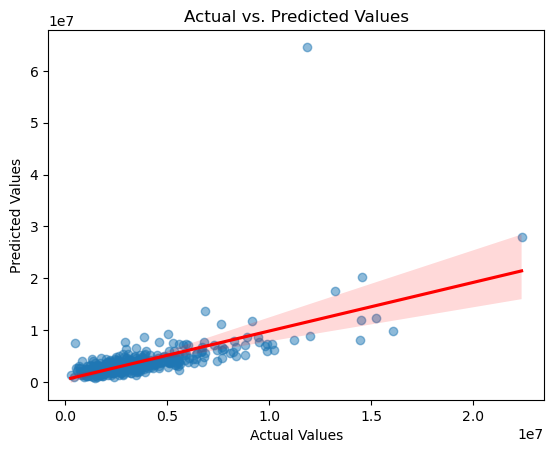

In [193]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rr, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

In [194]:
model_scores

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Linear Regression,reduced_robust,False,1.508451e+06,3.040478e+06,1.034526e+06,1.240234e+06,0.703222,-0.293243,0.59871,0.049294,-3.031149e+12,1.675553e+11,-1.150322e+06,37108.601699,None
1,Linear Regression,reduced_robust,True,1.508107e+06,3.054477e+06,1.034183e+06,1.241018e+06,0.703357,-0.305179,0.59871,0.049294,-3.031149e+12,1.675553e+11,-1.150322e+06,37108.601699,None


### Rounded

R2 Score: -0.2905530643855605, Root Mean Squared Error: 3036991.7533092485, Mean Absolute Error: 1240813.5266288759


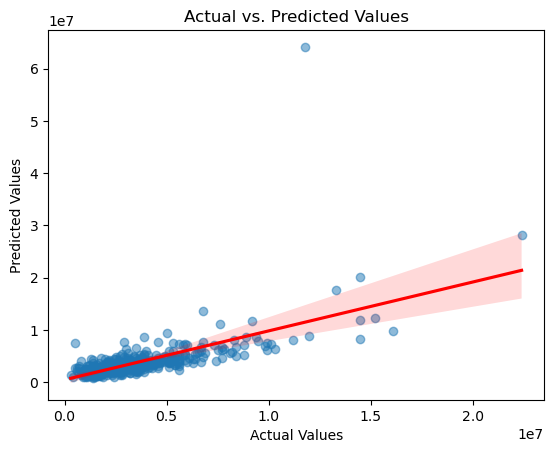

In [195]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rr, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_rr, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## II. Reduced & Power Transformed Data

### A. Linear Regression

In [196]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.5978091977488381, 0.01881284399679693),
 'neg_mean_squared_error': (-3061323848483.8022, 202302986007.34518),
 'neg_mean_absolute_error': (-1224908.2178983926, 68628.52430286654)}

R2 Score: 0.6479558389841737, Root Mean Squared Error: 1586354.9968192321, Mean Absolute Error: 1181633.1993025062


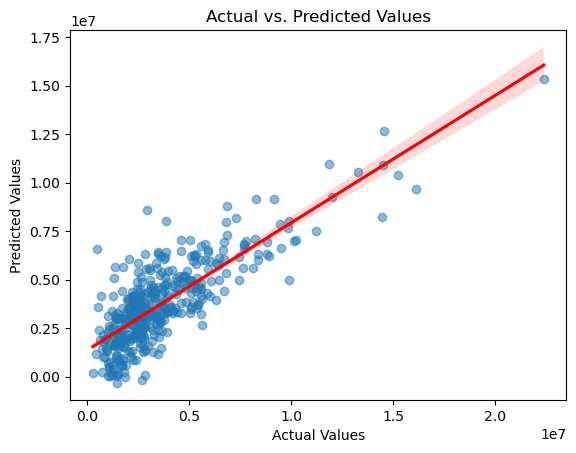

In [197]:
linear_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### B. Linear Regression with PCA

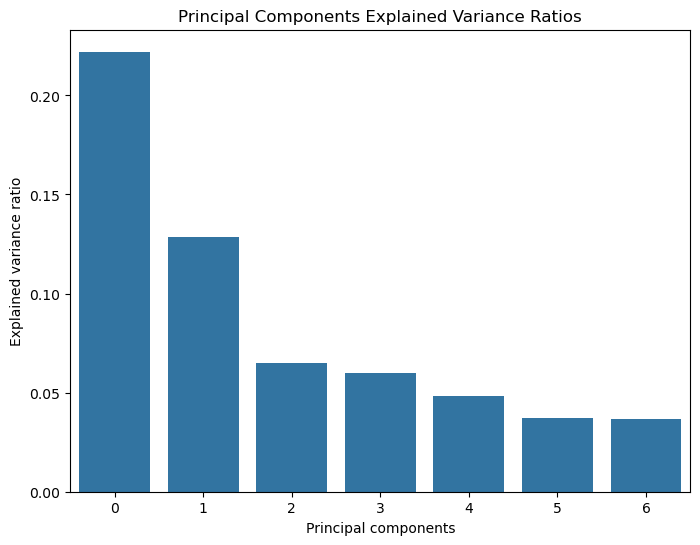

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_patients               0.265807  0.110611 -0.003689 -0.027402 -0.024617   
medicaid                     0.259587  0.071186  0.017149 -0.112298 -0.017230   
low_income                   0.256571 -0.011948  0.039795  0.013814 -0.148116   
hispanic_any_race            0.250709 -0.066223 -0.111752  0.107282  0.098344   
lep_patients                 0.240606 -0.099569 -0.127119  0.070508  0.113719   
uninsured                    0.237310 -0.035644 -0.045658  0.116938 -0.017675   
total_grant_funding          0.234946  0.018797  0.020943 -0.005128  0.057818   
TotalWeeklyHoursOfOperation  0.220936  0.121135  0.082050  0.024823 -0.149394   
total_sites                  0.209348  0.115553  0.100488  0.029743 -0.172238   
ZipCode_Count                0.208358  0.050679  0.045931 -0.061415  0.006416   
diverse_patients_sum         0.195785 -0.040353  0.111697 -0.220186 -0.058260   
medicare_18_up              

In [198]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_rp)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_rp)
X_test_pca = pca.transform(X_test_rp)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_rp.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))


In [199]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_rp.index)
X_train_pca_rp = pd.concat([X_train_rp, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_rp.index)

X_test_pca_rp = pd.concat([X_test_rp, X_test_pca_df], axis=1)

R2 Score: 0.6423554488824679, Root Mean Squared Error: 1598923.2384462652, Mean Absolute Error: 1185146.0796494144


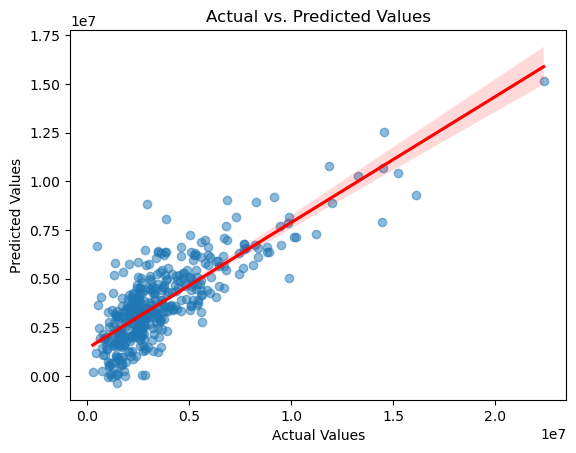

In [200]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_rp, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

In [201]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_rp, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores



{'r2': (0.5975882070881171, 0.01890230416912608),
 'neg_mean_squared_error': (-3063557657999.8525, 201073011108.3946),
 'neg_mean_absolute_error': (-1226610.134146704, 68735.18835199255)}

R2 Score: 0.6482774845721363, Root Mean Squared Error: 1585461.7344441246, Mean Absolute Error: 1181161.266882975


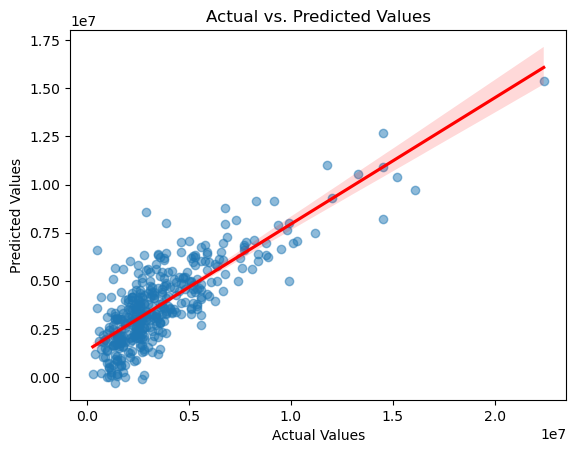

In [202]:
linear_model.fit(X_train_rp, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'reduced_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## III. Imputed & Robust Scaled Data

### A. Linear Regression

In [203]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.5841375845244934, 0.04929115090975368),
 'neg_mean_squared_error': (-3146023652618.357, 213180053317.71664),
 'neg_mean_absolute_error': (-1166114.1258730213, 37196.09727342724)}

R2 Score: -0.24113265528003303, Root Mean Squared Error: 2978591.2498694533, Mean Absolute Error: 1242208.5400343945


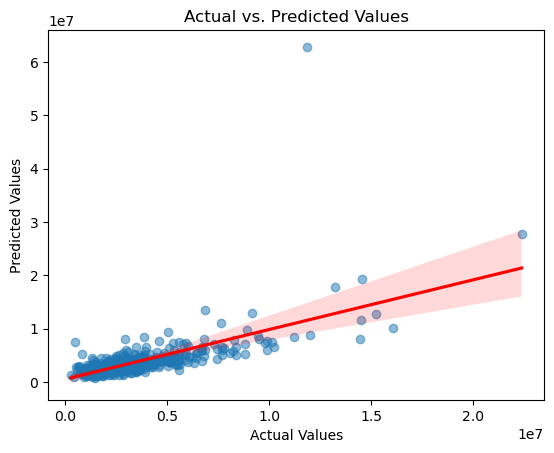

In [204]:
linear_model.fit(X_train_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

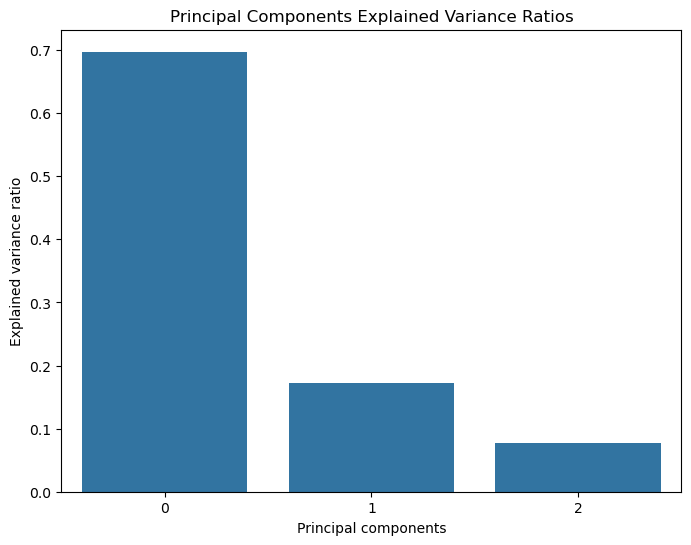

                             PC 1      PC 2      PC 3
public_insurance         0.955738  0.002405 -0.288683
public_insurance_ratio   0.291960 -0.054228  0.951954
public_housing_patients  0.012534  0.031671 -0.029995
total_other_revenue      0.011527  0.006756 -0.031593
lep_patients             0.011414  0.030907 -0.020538
migrant_patients         0.011207  0.981703  0.058219
hispanic_any_race        0.009480  0.044305 -0.018634
total_cost_care          0.008179  0.022114 -0.019557
total_visits             0.007682  0.025102 -0.017194
total_sfs                0.007582  0.015270 -0.015347
medicaid                 0.007024  0.028843 -0.016228
total_patients           0.006974  0.022175 -0.015885
uninsured                0.006939  0.015616 -0.013804
diverse_patients_sum     0.006902  0.003621 -0.012257
enabling_patients        0.006833  0.011118 -0.013656


In [205]:
# create PCA object
pca = PCA(n_components=3)

pca.fit(X_train_ir)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ir)
X_test_pca = pca.transform(X_test_ir)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3'], 
                        index=X_train_ir.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [206]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_train_ir.index)
X_train_pca_ir = pd.concat([X_train_ir, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3'], 
                              index=X_test_ir.index)
X_test_pca_ir = pd.concat([X_test_ir, X_test_pca_df], axis=1)


R2 Score: -0.24102781123633044, Root Mean Squared Error: 2978465.4397293343, Mean Absolute Error: 1242037.1935483871


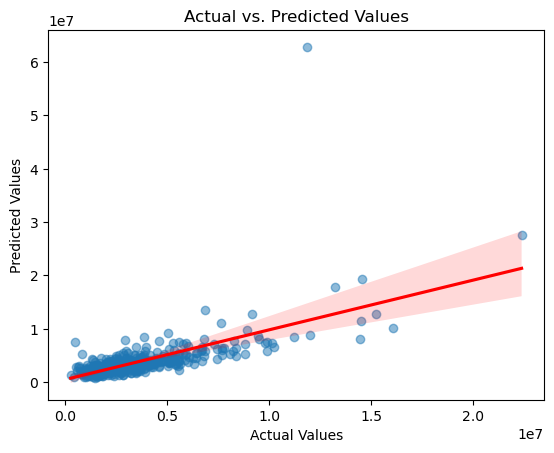

In [207]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ir, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ir, X_test_pca_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: -0.24083960942700067, Root Mean Squared Error: 2977923.2714309706, Mean Absolute Error: 1242558.506814012


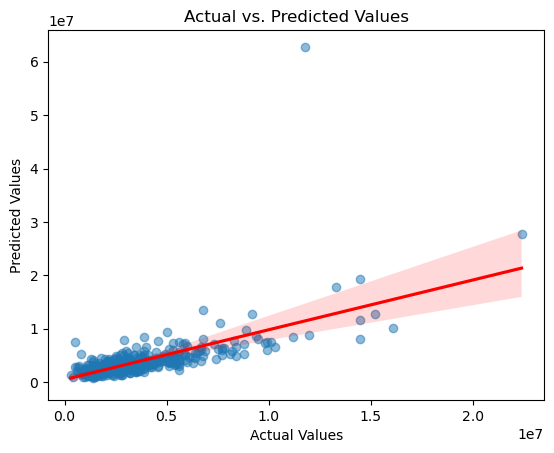

In [208]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ir, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ir, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

## IV. Imputed & Power Transformed Data

### A. Linear Regression

In [209]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores


{'r2': (0.5953357866220951, 0.018926158746890777),
 'neg_mean_squared_error': (-3083386174679.3955, 246247451684.60745),
 'neg_mean_absolute_error': (-1236019.8346411653, 62415.884105066594)}

R2 Score: 0.64756137354869, Root Mean Squared Error: 1587243.5032772939, Mean Absolute Error: 1181993.497055347


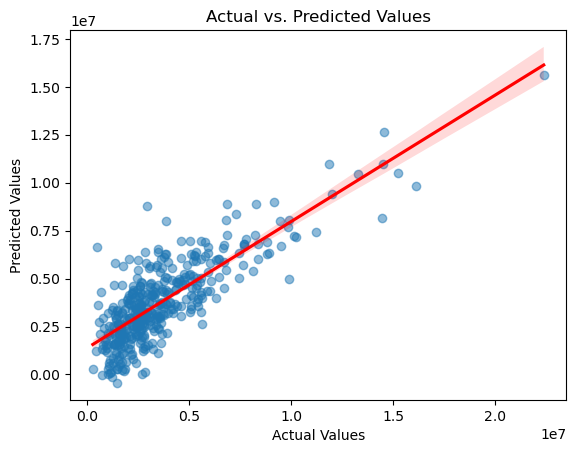

In [210]:
linear_model.fit(X_train_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Linear Regression PCA

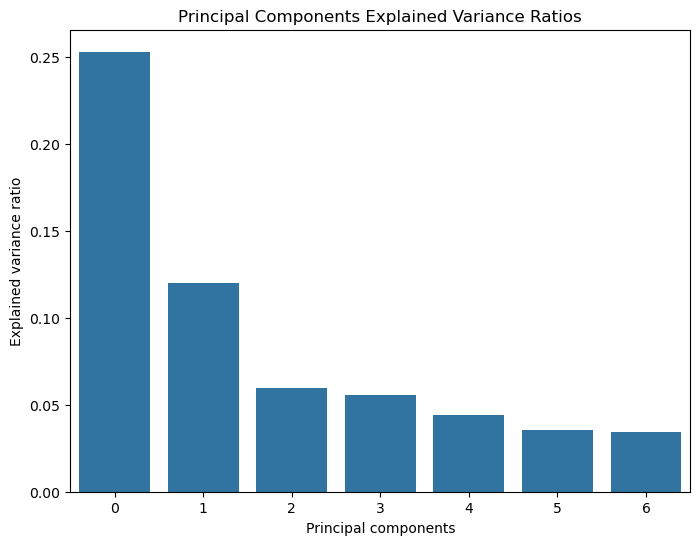

                                 PC 1      PC 2      PC 3      PC 4      PC 5  \
total_visits                 0.243157  0.085916  0.019416 -0.024041 -0.009643   
total_patients               0.241771  0.097790 -0.007228 -0.035245 -0.026413   
total_cost_care              0.237923  0.085012  0.049135 -0.022481  0.041036   
medicaid                     0.233098  0.060715  0.022080 -0.124347 -0.017644   
low_income                   0.229900 -0.023680  0.034594  0.006164 -0.149359   
hispanic_any_race            0.222954 -0.078738 -0.119696  0.085744  0.098840   
total_grant_funding          0.214417  0.007788  0.021033 -0.008436  0.056894   
uninsured                    0.214083 -0.049585 -0.061038  0.112755 -0.018674   
lep_patients                 0.211650 -0.110635 -0.132472  0.046837  0.114101   
TotalWeeklyHoursOfOperation  0.199154  0.108534  0.074333  0.023273 -0.153851   
total_sfs                    0.197152 -0.042281 -0.074492  0.094049  0.005666   
ZipCode_Count               

In [211]:
# create PCA object
pca = PCA(n_components=7)

pca.fit(X_train_ip)

features = range(pca.n_components_)

X_train_pca = pca.transform(X_train_ip)
X_test_pca = pca.transform(X_test_ip)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=features, y=pca.explained_variance_ratio_)
ax.set(xlabel='Principal components', 
       ylabel='Explained variance ratio', 
       title='Principal Components Explained Variance Ratios')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                        index=X_train_ip.columns)

print(loadings.sort_values('PC 1', ascending=False).head(15))

In [212]:
X_train_pca_df = pd.DataFrame(X_train_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_train_ip.index)
X_train_pca_ip = pd.concat([X_train_ip, X_train_pca_df], axis=1)

X_test_pca_df = pd.DataFrame(X_test_pca, 
                              columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7'], 
                              index=X_test_ip.index)

X_test_pca_ip = pd.concat([X_test_ip, X_test_pca_df], axis=1)



R2 Score: 0.6380515194497707, Root Mean Squared Error: 1608515.266047932, Mean Absolute Error: 1188831.0283218732


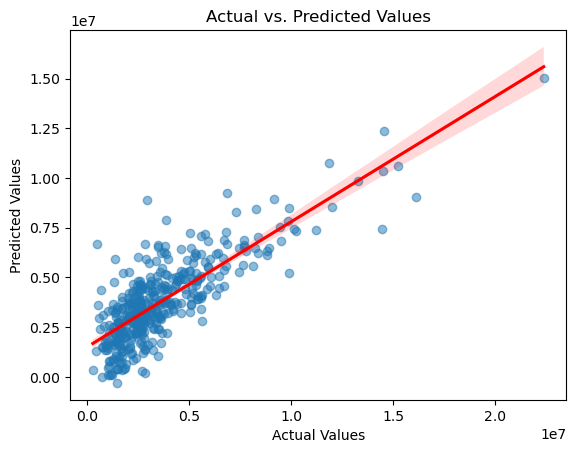

In [213]:
linear_model = LinearRegression()

linear_model.fit(X_train_pca_ip, y_train)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_pca_ip, X_test_pca_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [214]:
add_model_score('Linear Regression', 'imputed_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

### Rounded

R2 Score: 0.6478469720575089, Root Mean Squared Error: 1586431.749655295, Mean Absolute Error: 1180932.8651215837


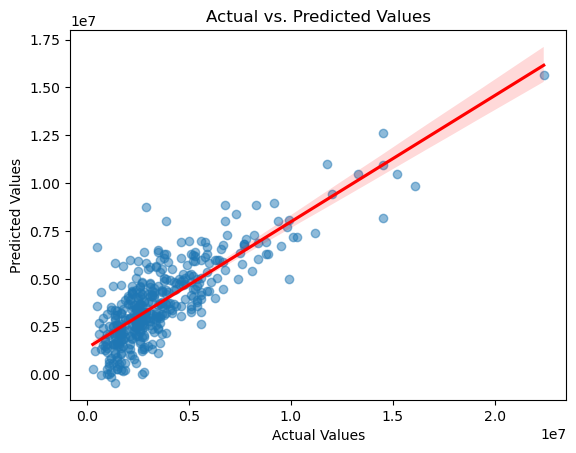

In [215]:
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=48)

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

scores = {}

for score in scoring:
    cv_results = cross_val_score(linear_model, X_train_ip, y_train_rounded, scoring=score, cv=kf)
    scores[score] = (cv_results.mean(), cv_results.std())

scores

linear_model.fit(X_train_ip, y_train_rounded)
y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(linear_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

add_model_score('Linear Regression', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                scores['r2'][0], scores['r2'][1], 
                scores['neg_mean_squared_error'][0], scores['neg_mean_squared_error'][1], 
                scores['neg_mean_absolute_error'][0], scores['neg_mean_absolute_error'][1])

# Scores Analysis

In [216]:
model_scores.sort_values('cv_mean_r2',ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
2,Linear Regression,reduced_robust_rounded,False,1.508287e+06,3.036992e+06,1.034581e+06,1.240814e+06,0.703325,-0.290553,0.598756,0.048830,-3.031920e+12,1.690306e+11,-1.150427e+06,37008.189965,None
0,Linear Regression,reduced_robust,False,1.508451e+06,3.040478e+06,1.034526e+06,1.240234e+06,0.703222,-0.293243,0.598710,0.049294,-3.031149e+12,1.675553e+11,-1.150322e+06,37108.601699,None
1,Linear Regression,reduced_robust,True,1.508107e+06,3.054477e+06,1.034183e+06,1.241018e+06,0.703357,-0.305179,0.598710,0.049294,-3.031149e+12,1.675553e+11,-1.150322e+06,37108.601699,None
3,Linear Regression,reduced_power,False,1.613415e+06,1.586355e+06,1.130684e+06,1.181633e+06,0.660483,0.647956,0.597809,0.018813,-3.061324e+12,2.023030e+11,-1.224908e+06,68628.524303,None
4,Linear Regression,reduced_power,True,1.619470e+06,1.598923e+06,1.133923e+06,1.185146e+06,0.657930,0.642355,0.597809,0.018813,-3.061324e+12,2.023030e+11,-1.224908e+06,68628.524303,None
5,Linear Regression,reduced_power_rounded,False,1.614146e+06,1.585462e+06,1.132288e+06,1.181161e+06,0.660220,0.648277,0.597588,0.018902,-3.063558e+12,2.010730e+11,-1.226610e+06,68735.188352,None
9,Linear Regression,imputed_power,False,1.603669e+06,1.587244e+06,1.127989e+06,1.181993e+06,0.664572,0.647561,0.595336,0.018926,-3.083386e+12,2.462475e+11,-1.236020e+06,62415.884105,None
10,Linear Regression,imputed_power,True,1.619451e+06,1.608515e+06,1.132977e+06,1.188831e+06,0.657938,0.638052,0.595336,0.018926,-3.083386e+12,2.462475e+11,-1.236020e+06,62415.884105,None
11,Linear Regression,imputed_power_rounded,False,1.604360e+06,1.586432e+06,1.129466e+06,1.180933e+06,0.664327,0.647847,0.595048,0.019240,-3.086108e+12,2.458439e+11,-1.237485e+06,62852.226495,None
6,Linear Regression,imputed_robust,False,1.500967e+06,2.978591e+06,1.034292e+06,1.242209e+06,0.706159,-0.241133,0.584138,0.049291,-3.146024e+12,2.131801e+11,-1.166114e+06,37196.097273,None


# Ensemble Models

## I. Reduced & Robust Scaled Data

##### Importing Data

### C. Random Forest Regression

In [217]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rr, y_train)

y_pred = rf_gridsearch.predict(X_test_rr)
print(rf_gridsearch.score(X_test_rr, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6497217669972903
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 10, 'n_estimators': 200, 'n_jobs': -1}


R2 Score: 0.6430669582322388, Root Mean Squared Error: 1597331.972464006, Mean Absolute Error: 1106715.1010669975


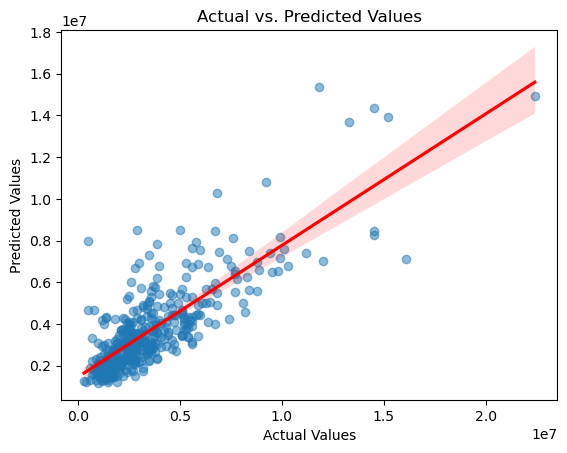

                             feature_importance
uninsured                              0.106133
total_patients                         0.085927
low_income                             0.077487
TotalWeeklyHoursOfOperation            0.058536
medicaid                               0.051261
total_grant_funding                    0.045873
hispanic_any_race                      0.043452
total_sites                            0.040724
diverse_patients_sum                   0.030505
medicare_18_up                         0.027633
ZipCode_Count                          0.024996
private_insurance                      0.023367
lep_patients                           0.023332
homeless_patients                      0.020835
SiteCity_Count                         0.018347


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_9773/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [218]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.64213430798518, Root Mean Squared Error: 1599417.4898998104, Mean Absolute Error: 1109413.9922518611


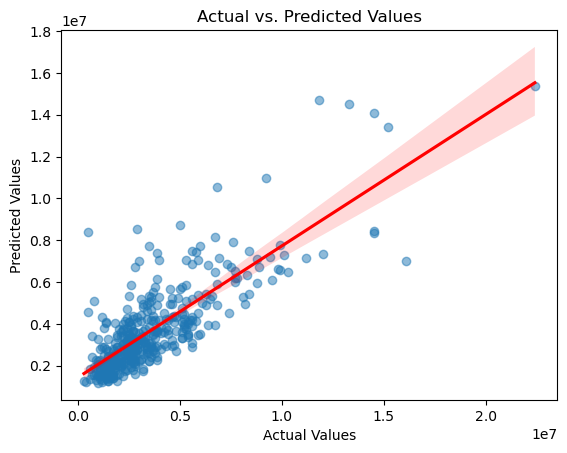

                             feature_importance
uninsured                              0.102606
total_patients                         0.099542
low_income                             0.072697
TotalWeeklyHoursOfOperation            0.065341
medicaid                               0.044789
hispanic_any_race                      0.037754
total_grant_funding                    0.037274
total_sites                            0.036486
PC 3                                   0.028276
diverse_patients_sum                   0.028186
lep_patients                           0.024366
medicare_18_up                         0.022502
ZipCode_Count                          0.021876
PC 2                                   0.020802
private_insurance                      0.018427


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_9773/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [219]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rr, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rr, X_test_pca_rr, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6458323030166039, Root Mean Squared Error: 1590963.2692395758, Mean Absolute Error: 1098410.669975186


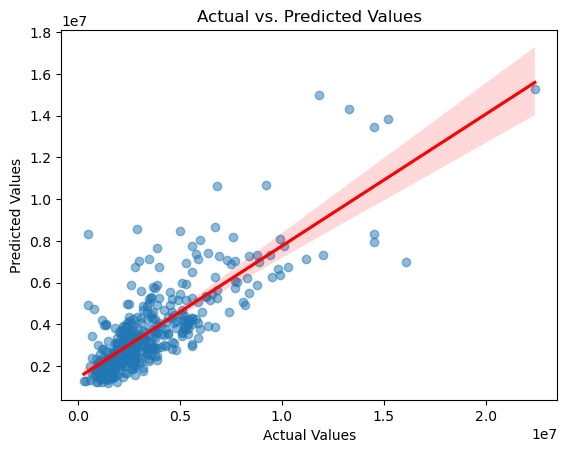

                             feature_importance
uninsured                              0.110349
total_patients                         0.101316
low_income                             0.072926
TotalWeeklyHoursOfOperation            0.064724
hispanic_any_race                      0.052605
medicaid                               0.050132
total_grant_funding                    0.038941
diverse_patients_sum                   0.034358
total_sites                            0.029437
medicare_18_up                         0.023812
ZipCode_Count                          0.023554
lep_patients                           0.020829
homeless_patients                      0.020354
private_insurance                      0.019642
migrant_patients                       0.017277


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_9773/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [220]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rr, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rr, X_test_rr, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rr.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## II. Reduced & Power Transformed Data

##### Importing Data

### C. Random Forest Regressor with GridSearch

In [221]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_rp, y_train)

y_pred = rf_gridsearch.predict(X_test_rp)
print(rf_gridsearch.score(X_test_rp, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6586975421779586
Best parameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1}


R2 Score: 0.6608067782172268, Root Mean Squared Error: 1557131.859591405, Mean Absolute Error: 1091078.6116501242


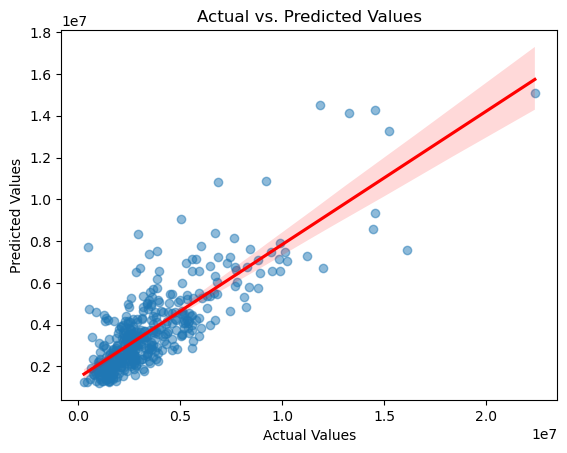

                             feature_importance
total_patients                         0.094211
uninsured                              0.093204
TotalWeeklyHoursOfOperation            0.077220
low_income                             0.067786
medicaid                               0.066592
total_grant_funding                    0.055390
hispanic_any_race                      0.048160
total_sites                            0.045166
diverse_patients_sum                   0.043050
lep_patients                           0.034056
medicare_18_up                         0.030658
private_insurance                      0.025130
homeless_patients                      0.023016
migrant_patients                       0.021681
SiteCity_Count                         0.019571


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_9773/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [222]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### D. RandomForestRegressor with PCA

R2 Score: 0.6660049393475401, Root Mean Squared Error: 1545154.2125622476, Mean Absolute Error: 1073062.0138833749


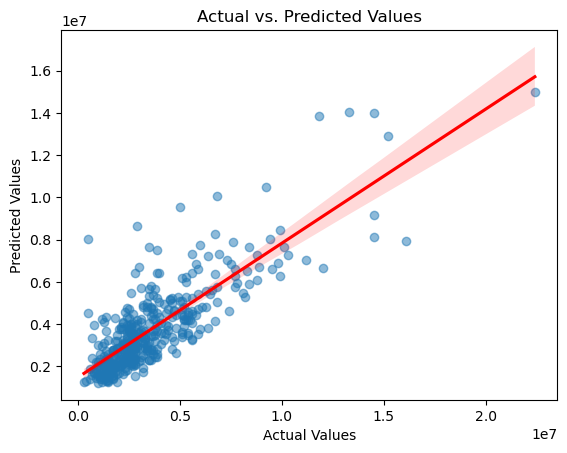

                             feature_importance
PC 1                                   0.091347
uninsured                              0.081986
total_patients                         0.080933
low_income                             0.064545
TotalWeeklyHoursOfOperation            0.063374
total_grant_funding                    0.048864
hispanic_any_race                      0.048298
medicaid                               0.043760
diverse_patients_sum                   0.036021
total_sites                            0.033892
private_insurance                      0.025927
lep_patients                           0.024658
ZipCode_Count                          0.021658
homeless_patients                      0.021568
medicare_18_up                         0.020792


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_9773/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [223]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6643963134521851, Root Mean Squared Error: 1548706.2138199634, Mean Absolute Error: 1086689.8263027295


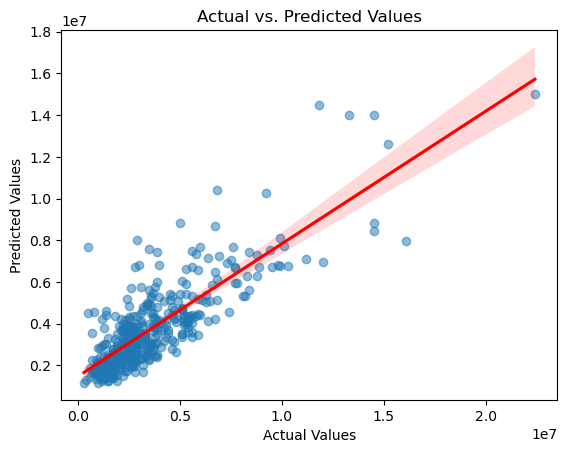

                             feature_importance
uninsured                              0.102592
total_patients                         0.087702
medicaid                               0.068087
low_income                             0.064630
TotalWeeklyHoursOfOperation            0.061864
hispanic_any_race                      0.056765
total_grant_funding                    0.054896
total_sites                            0.045483
lep_patients                           0.039060
diverse_patients_sum                   0.037921
medicare_18_up                         0.027346
migrant_patients                       0.023949
ZipCode_Count                          0.021801
private_insurance                      0.021059
SiteCity_Count                         0.020893


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_9773/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [224]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_rp, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_rp, X_test_rp, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'reduced_power_rounded', True, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## III. Imputed & Robust Scaled Data

##### Importing Data

### B. Random Forest Regressor

In [225]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, cv=kf)

rf_gridsearch.fit(X_train_ir, y_train)

y_pred = rf_gridsearch.predict(X_test_ir)
print(rf_gridsearch.score(X_test_ir, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6368345618687036
Best parameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6297546025200427, Root Mean Squared Error: 1626846.7438189609, Mean Absolute Error: 1131006.0503598016


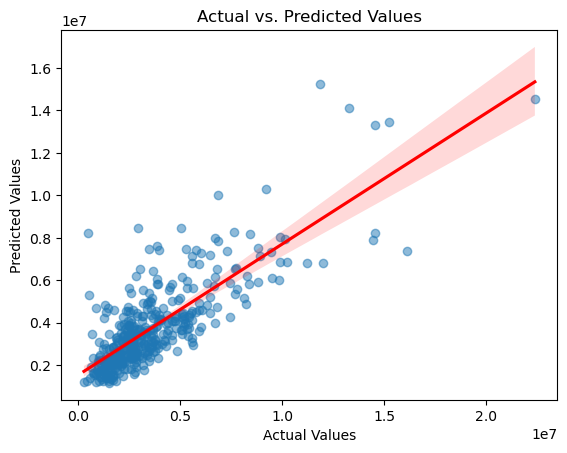

                             feature_importance
total_patients                         0.063798
uninsured                              0.062929
total_visits                           0.053339
total_cost_care                        0.046189
low_income                             0.045385
TotalWeeklyHoursOfOperation            0.043346
total_sfs                              0.036832
medicaid                               0.033077
total_grant_funding                    0.032213
hispanic_any_race                      0.030005
ZipCode_Count                          0.028549
diverse_patients_sum                   0.026314
total_sites                            0.026163
medicare_18_up                         0.025400
private_insurance                      0.021437


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_9773/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [226]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.6399755196648254, Root Mean Squared Error: 1604064.0128498923, Mean Absolute Error: 1107632.7543424317


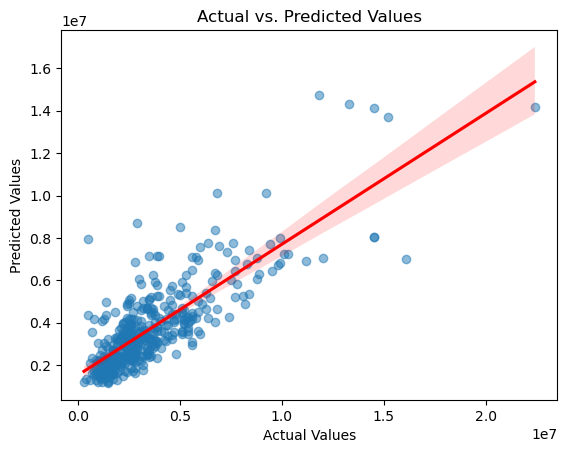

                             feature_importance
total_patients                         0.066639
total_visits                           0.063661
uninsured                              0.052134
low_income                             0.051725
TotalWeeklyHoursOfOperation            0.044650
total_cost_care                        0.040786
medicaid                               0.036187
hispanic_any_race                      0.035368
total_grant_funding                    0.033635
total_sites                            0.033620
total_sfs                              0.030350
lep_patients                           0.026506
diverse_patients_sum                   0.022999
medicare_18_up                         0.022927
ZipCode_Count                          0.022787


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_9773/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [227]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ir, X_test_ir, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ir.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_robust_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

## IV. Imputed & Power Transformed Data

##### Importing Data

### B. Random Forest Regressor

In [228]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

param_grid = {'n_estimators':[50, 100, 200],
              'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
              'max_depth':[5, 10, None],
              'n_jobs':[-1],
              'max_features':['sqrt', 'log2', None, 10, 20]}

rf_model = RandomForestRegressor()

rf_gridsearch = GridSearchCV(rf_model, param_grid=param_grid, scoring='r2', cv=kf)

rf_gridsearch.fit(X_train_ip, y_train)

y_pred = rf_gridsearch.predict(X_test_ip)
print(rf_gridsearch.score(X_test_ip, y_test))

best_params = rf_gridsearch.best_params_
print("Best parameters:", best_params)

0.6234949078268246
Best parameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 20, 'n_estimators': 50, 'n_jobs': -1}


R2 Score: 0.5183420527073237, Root Mean Squared Error: 1855543.642261846, Mean Absolute Error: 1195598.0348883374


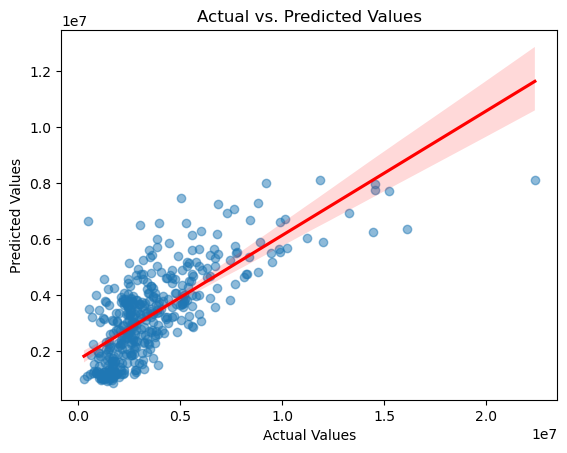

                             feature_importance
total_patients                         0.105875
uninsured                              0.097723
total_visits                           0.080627
total_cost_care                        0.055492
TotalWeeklyHoursOfOperation            0.050358
low_income                             0.049490
hispanic_any_race                      0.026711
diverse_patients_sum                   0.026113
medicaid                               0.023013
total_grant_funding                    0.020853
migrant_patients                       0.019302
total_sites                            0.018883
lep_patients                           0.017621
diverse_race_proportion                0.017383
medicaid_ratio                         0.016847


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_9773/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [229]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

### Rounded

R2 Score: 0.5242042104760014, Root Mean Squared Error: 1844021.484617793, Mean Absolute Error: 1204997.5186104218


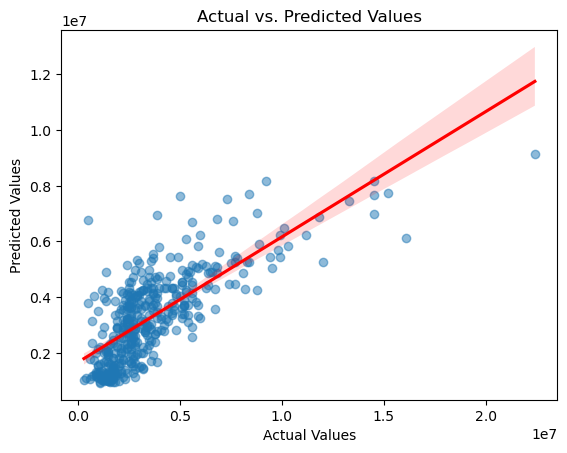

                             feature_importance
uninsured                              0.120548
total_patients                         0.084520
total_visits                           0.072140
total_cost_care                        0.061611
TotalWeeklyHoursOfOperation            0.046942
low_income                             0.046491
medicaid                               0.037320
total_grant_funding                    0.025896
hispanic_any_race                      0.024644
total_sfs                              0.022443
diverse_patients_sum                   0.017727
homeless_patients                      0.017699
lep_patients                           0.017656
medicaid_ratio                         0.017420
total_sites                            0.017339


/var/folders/b2/nkpmrw0s42q_zm32rwshljyr0000gn/T/ipykernel_9773/161813126.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores = pd.concat([model_scores, new_row_df], axis=0, ignore_index=True)


In [230]:
rf_model = RandomForestRegressor(**best_params)

rf_model.fit(X_train_ir, y_train_rounded)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model, X_train_ip, X_test_ip, y_train_rounded, y_test_rounded)

sns.regplot(x=y_test_rounded.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_ip.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

add_model_score('Random Forest Regressor', 'imputed_power_rounded', False, 
                rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test,
                None, None, None, None, None, None,
                best_params=rf_model.get_params())

# Scoring Summary

In [52]:
model_scores.sort_values('score_r2_test', ascending=False)

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
16,Random Forest Regressor,reduced_power,True,7.690396e+05,1.759344e+06,5.492460e+05,1.146775e+06,0.913406,0.659532,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
12,Random Forest Regressor,reduced_robust,False,7.051991e+05,1.760343e+06,5.180258e+05,1.135823e+06,0.927186,0.659145,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
19,Random Forest Regressor,imputed_robust_rounded,False,5.741328e+05,1.762452e+06,3.866940e+05,1.149963e+06,0.951721,0.658596,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
14,Random Forest Regressor,reduced_robust_rounded,False,6.958064e+05,1.766296e+06,5.195409e+05,1.134421e+06,0.929089,0.657105,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
18,Random Forest Regressor,imputed_robust,False,5.902384e+05,1.773155e+06,3.983909e+05,1.161507e+06,0.948991,0.654165,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
13,Random Forest Regressor,reduced_robust,True,7.063103e+05,1.780863e+06,5.235446e+05,1.152878e+06,0.926957,0.651152,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
15,Random Forest Regressor,reduced_power,False,7.651279e+05,1.788769e+06,5.528516e+05,1.158296e+06,0.914285,0.648048,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
17,Random Forest Regressor,reduced_power_rounded,True,7.585296e+05,1.789645e+06,5.456482e+05,1.163845e+06,0.915729,0.647979,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
1,Linear Regression,reduced_robust,True,1.441341e+06,1.810084e+06,1.019353e+06,1.166834e+06,0.695826,0.639610,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None
0,Linear Regression,reduced_robust,False,1.427076e+06,1.819935e+06,1.012823e+06,1.163950e+06,0.701817,0.635677,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None


In [53]:
best_forest = model_scores[model_scores['model_type'] == 'Random Forest Regressor']\
                .sort_values('score_r2_test', ascending=False).head(2)
best_linreg = model_scores[model_scores['model_type'] == 'Linear Regression']\
                .sort_values('score_r2_test', ascending=False).head(2)

top_models = pd.concat([best_forest, best_linreg], ignore_index=True)
top_models

,model_type,train_test_split,is_pca,score_rmse_train,score_rmse_test,score_mae_train,score_mae_test,score_r2_train,score_r2_test,cv_mean_r2,cv_std_r2,cv_mean_rmse,cv_std_rmse,cv_mean_mae,cv_std_mae,best_params
0,Random Forest Regressor,reduced_power,True,7.690396e+05,1.759344e+06,5.492460e+05,1.146775e+06,0.913406,0.659532,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
1,Random Forest Regressor,reduced_robust,False,7.051991e+05,1.760343e+06,5.180258e+05,1.135823e+06,0.927186,0.659145,NaN,NaN,NaN,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
2,Linear Regression,reduced_robust,True,1.441341e+06,1.810084e+06,1.019353e+06,1.166834e+06,0.695826,0.639610,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None
3,Linear Regression,reduced_robust,False,1.427076e+06,1.819935e+06,1.012823e+06,1.163950e+06,0.701817,0.635677,-0.101058,1.438584,-6.901222e+12,8.453883e+12,-1.163470e+06,131911.476683,None


In [69]:
# best_params for the first rf model
best_params_first_model = top_models.loc[0, 'best_params']
print(best_params_first_model)

# best_params for the second rf model
best_params_second_model = top_models.loc[1, 'best_params']
print(best_params_second_model)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# Model Tuning

### **Reduced Power Model with PCA Features**

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}



In [72]:
kf = KFold(n_splits=5, shuffle=True, random_state=48)

forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [90, 100, 130], 
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 10, 20, 'log2'], 
    'min_samples_split': [2, 3, 5], 
    'min_samples_leaf': [1, 2, 4],  
    'criterion': ['absolute_error', 'friedman_mse', 'squared_error'], 
    'bootstrap': [True],  
    'n_jobs': [-1], 
}

forest_gs = GridSearchCV(forest_model, param_grid=param_grid, cv=kf)

forest_gs.fit(X_train_pca_rp, y_train)

y_pred = forest_gs.predict(X_test_pca_rp)
print(forest_gs.score(X_test_pca_rp, y_test))

best_params = forest_gs.best_params_
print("Best parameters:", best_params)

0.6587402959737183
Best parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


R2 Score: 0.6621142211476213, Root Mean Squared Error: 1752659.3727011054, Mean Absolute Error: 1139253.093420398


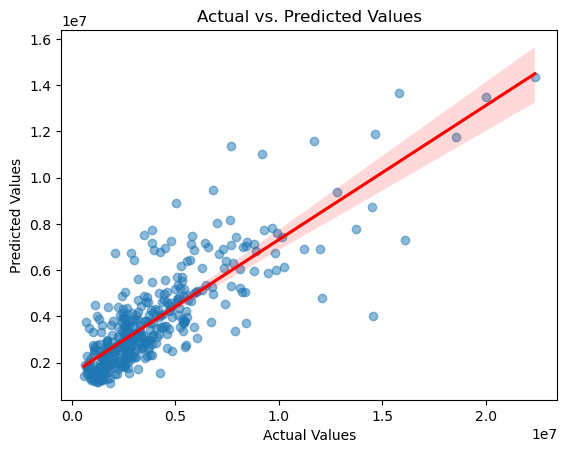

                             feature_importance
PC 1                                   0.152718
total_patients                         0.115656
uninsured                              0.102920
TotalWeeklyHoursOfOperation            0.067786
hispanic_any_race                      0.035166
low_income                             0.030817
total_grant_funding                    0.030002
medicaid                               0.027641
total_sites                            0.019645
PC 4                                   0.018066
SiteCity_Count                         0.015362
private_insurance                      0.014797
medicare_18_up                         0.014212
diverse_patients_sum                   0.014023
medicaid_ratio                         0.013977


In [75]:
rf_model_1 = RandomForestRegressor(**best_params, random_state=33)

rf_model_1.fit(X_train_pca_rp, y_train)

y_pred = None

rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(rf_model_1, X_train_pca_rp, X_test_pca_rp, y_train, y_test)

sns.regplot(x=y_test.flatten(), y=y_pred.flatten(), scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

rf_important_features = pd.DataFrame(rf_model_1.feature_importances_,
                                     columns=['feature_importance'],
                                     index=X_train_pca_rp.columns)

print(rf_important_features.sort_values('feature_importance', ascending=False).head(15))

In [76]:
y_pred_train = rf_model_1.predict(X_train_pca_rp)

In [77]:
residuals = y_test - y_pred

# Create a DataFrame to analyze the residuals
results_df = pd.DataFrame({
    'Actual': y_test.flatten(), 
    'Predicted': y_pred.flatten(),
    'Residuals': residuals.flatten(),
    'Absolute_Residuals': abs(residuals).flatten()
})

# Sort the df by absolute residuals in descending order
results_df = results_df.sort_values(by='Absolute_Residuals', ascending=False)

results_df[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,402.00
mean,1139253.09
std,1333544.52
min,7117.86
25%,333823.93
50%,734507.27
75%,1392731.36
max,10551145.46


In [78]:
residuals_train = y_train - y_pred_train

# Create a DataFrame to analyze the residuals
results_df_train = pd.DataFrame({
    'Actual': y_train.flatten(), 
    'Predicted': y_pred_train.flatten(),
    'Residuals': residuals_train.flatten(),
    'Absolute_Residuals': abs(residuals_train).flatten()
})

# Sort the df by absolute residuals in descending order
results_df_train = results_df_train.sort_values(by='Absolute_Residuals', ascending=False)

In [79]:
combined_data_test = pd.merge(X_test_rr, results_df, left_index=True, right_index=True, how='inner')

combined_data_train = pd.merge(X_train_rr, results_df_train, left_index=True, right_index=True, how='inner')
combined_data = pd.concat([combined_data_train, combined_data_test], axis=0)

In [80]:
df = pd.read_csv(DATA_PATH +'modeling/data_new_features.csv')
df.shape

(1340, 74)

In [85]:
combined_data = pd.merge(combined_data_test, df[['HealthCenterName', 'HealthCenterState']], left_index=True, right_index=True, how='inner')


In [89]:
combined_data.head(2)

,FundingCHC,FundingMHC,FundingHO,FundingPH,total_other_revenue,hispanic_any_race,total_patients,lep_patients,medicare_18_up,migrant_patients,...,other_revenue_category_1M to 30M,other_revenue_category_Less than 100K,other_revenue_category_Over 30M,other_revenue_category_Zero,Actual,Predicted,Residuals,Absolute_Residuals,HealthCenterName,HealthCenterState
0,0.0,0.0,0.0,0.0,0.172906,0.07084,0.126890,0.833120,-0.075277,-0.208909,...,0.0,0.0,0.0,0.0,2547838,3594789.440,-1046951.440,1046951.440,"HOLYOKE HEALTH CENTER, INC.",MA
1,0.0,0.0,0.0,0.0,-0.268738,-0.05062,1.380709,-0.242674,1.579095,-0.208909,...,0.0,0.0,0.0,1.0,2425436,4877260.235,-2451824.235,2451824.235,MAINE MOBILE HEALTH PROGRAM INC.,ME


In [87]:
combined_data[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

,Absolute_Residuals
count,402.00
mean,1139253.09
std,1333544.52
min,7117.86
25%,333823.93
50%,734507.27
75%,1392731.36
max,10551145.46


In [88]:
combined_data.groupby('HealthCenterState')[['Absolute_Residuals']].describe().apply(lambda x: x.apply('{0:.2f}'.format))

Absolute_Residuals                                     \
                               count        mean         std        min   
HealthCenterState                                                         
AL                              5.00  2250663.04  2716957.35   10075.89   
CT                             16.00  1539461.00  1898507.03  130087.86   
DC                              8.00   517440.48   489154.06  124330.56   
DE                              3.00   274140.76   169892.26   92619.97   
FL                             26.00   932765.35   970455.42   10875.51   
GA                             10.00   651582.17   845297.72   43750.90   
KY                              7.00   842996.79   677528.60   74159.62   
MA                             37.00  1168224.77  1211859.30   70974.88   
MD                             17.00  1209872.84   958062.79   11690.26   
ME                             18.00  1150947.00  1004606.87   43965.10   
MS                             10.00  1302751.91  1640458.98   83088.46   
NC                              9.00   753749.32   738351.29   65779.08   
NH                              9.00  1472626.58  1204763.36  206045.83   
NJ                             23.00  1062370.52  1412846.11  131653.47   
NY                             63.00  1106589.90  1154095.90   40771.24   
PA                             42.00   947988.06   876577.95    7117.86   
RI                              8.00  1094769.98   720885.40  116607.76   
SC                             10.00  1529254.33  2640338.46   92458.81   
TN                             16.00  1833722.77  2122666.16   92838.59   
VA                             26.00  1005963.25   981107.09  287067.81   
VT                             11.00  2354838.76  2886095.90   32309.12   
WV                             28.00   838449.39   853863.43   43839.68   

                                                                    
                          25%         50%         75%          max  
HealthCenterState                                                   
AL                  212621.68   744040.20  4321976.75   5964600.67  
CT                  374524.73   853547.32  1723875.82   7294754.96  
DC                  183681.74   362157.53   607272.32   1557065.17  
DE                  196546.31   300472.65   364901.15    429329.66  
FL                  240531.12   728597.31   997341.11   3872067.69  
GA                  210489.18   230849.15   775816.14   2781156.19  
KY                  215775.92  1007780.09  1283058.86   1821368.26  
MA                  402775.63   968107.48  1471702.83   6530249.54  
MD                  554680.05   954412.71  1470572.83   3327509.25  
ME                  334930.73   815668.40  1653485.16   3442689.57  
MS                  503311.75   838380.98  1186868.82   5786033.40  
NC                  418669.00   548762.32   703027.72   2613658.67  
NH                  549970.97  1321837.38  2178336.95   3912151.07  
NJ                  378343.80   658743.20  1040716.33   6801302.35  
NY                  327447.08   715484.91  1281290.31   4679019.08  
PA                  324338.81   726069.17  1381278.29   3627319.36  
RI                  624528.14   988987.61  1620203.98   2154639.65  
SC                  197836.02   640475.81  1447280.74   8814568.00  
TN                  754657.29  1050887.73  1923495.62   8028933.55  
VA                  460107.61   687473.49  1047535.56   4052491.18  
VT                 1014504.78  1660560.10  2534017.19  10551145.46  
WV                  325355.65   496094.83  1183009.02   3881449.66

# Results

The model called rf_model_1 performed the best in terms of R2 score. This model was trained and tested with the Reduced Power train/test split that also included PCA features in the dataset. 

Here were the results:

R2 Score: 0.6621142211476213, Root Mean Squared Error: 1752659.3727011054, Mean Absolute Error: 1139253.093420398

The linear regression models and random forest regressors performed better using the reduced dataset, which columns containing a lot of values were removed instead of imputed.